
# Working with MINTe: Python emulator for malaria intervention scenarios

This notebook walks through how to:

1. Install the MINTverse Python packages
2. Map common **R** idioms (MINTer / MINTweb) to **Python**
3. Run **single** and **multiple** scenarios with `run_minter_scenarios`
4. Understand the **outputs** (prevalence, cases, scenario metadata)
5. Explore results in tabular form (`.head()`, filtering, grouping)
6. Use the built-in plotting helper `create_scenario_plots`
7. Export results to `.csv` for further analysis

We treat the ML models as a **black box surrogate** for `malariasimulation`:

- You provide: baseline setting + intervention package(s)  
- MINTe returns: predicted prevalence and clinical cases over time



## 1. Installation

You only need to run the installation **once per environment**.

In most setups you will either:

- Install from PyPI or  
- Install directly from the GitHub repositories.

If you're on an HPC or managed environment, please speak to me after (Docs are not written yet for this).


In [1]:

# Let's install minte
!pip install minte

# Otherwise, install directly from GitHub:
# !pip install "git+https://github.com/CosmoNaught/MINTe-python.git"
# !pip install "git+https://github.com/CosmoNaught/estiMINT-python.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 112.9 MB/s eta 0:00:00



## 2. Common R → Python equivalents

Most of what you did in R with **MINTer / MINTweb** and **tidyverse** has a direct
analogue in **Python + pandas**.

| Task                                  | R / tidyverse                                      | Python / pandas                                           |
|--------------------------------------|-----------------------------------------------------|-----------------------------------------------------------|
| Data frame                           | `data.frame()`, `tibble()`                         | `pd.DataFrame()`                                          |
| Read CSV                             | `readr::read_csv("x.csv")`                         | `pd.read_csv("x.csv")`                                    |
| Filter rows                          | `df %>% filter(var == 1)`                          | `df[df["var"] == 1]`                                      |
| Select columns                       | `df %>% select(a, b)`                              | `df[["a", "b"]]`                                          |
| Arrange / sort                       | `df %>% arrange(a)`                                | `df.sort_values("a")`                                     |
| Grouped summary                      | `df %>% group_by(a) %>% summarise(mean(b))`        | `df.groupby("a")["b"].mean().reset_index()`               |
| Pipe                                 | `%>%`                                              | chain methods: `df.query(...).groupby(...).mean()`        |
| Run scenarios                        | `run_mintweb_controller(...)`                      | `run_minter_scenarios(...)`                               |
| Missing value (numeric)              | `NA_real_`                                         | `numpy.nan` (imported as `np.nan`)                        |
| Missing value (string)               | `NA_character_`                                    | `None`                                                    |

Conceptually:

- In R you passed **vectors** (`c(0.3, 0.5, 0.7)`);  
  in Python you pass **lists** or **NumPy arrays** (`[0.3, 0.5, 0.7]` or `np.array([...])`).
- `run_minter_scenarios` is the Python analogue of `run_mintweb_controller`:
  you give it vectors of parameters, and it runs **all scenarios at once**.



## 3. Imports and basic configuration

Here we import:

- `numpy` and `pandas` for data handling
- `run_minter_scenarios` – the main controller
- `create_scenario_plots` – a built-in plotting helper


In [2]:

import numpy as np
import pandas as pd

# Core MINTe API
from minte import run_minter_scenarios, create_scenario_plots

# Optional: make pandas print a bit more information
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)



## 4. What `run_minter_scenarios` does

At a high level, `run_minter_scenarios`:

1. **Back-calculates EIR** from current prevalence and interventions  
   using the pre-trained **estiMINT XGBoost** model.
2. Builds a **scenario table** with:
   - baseline EIR
   - current and future ITN/IRS/LSM
   - vector behaviour (`Q0`, `phi_bednets`)
   - resistance & net quality (`dn0_use`, `dn0_future`)
3. Runs the **neural emulator** to predict:
   - under-5 daily prevalence trajectories
   - all-age daily clinical incidence trajectories per 1000
4. Returns a results object (similar to an R list) with:

```text
results.prevalence   # DataFrame of prevalence over time for each scenario
results.cases        # DataFrame of clinical cases over time for each scenario
results.scenario_meta# Per-scenario metadata, incl. EIR validity
results.eir_valid    # True/False flag
results.benchmarks   # (optional) runtime timings
```

In this notebook we treat the ML models as a **black box**: you don't have to
write or edit any neural-network code to use MINTe.



## 5. A single simple scenario

Here we run **one** scenario by passing **1-element lists**.
This is conceptually the same as a one-row data frame in R.


In [3]:

# Example: a single scenario
scenario_tag   = ["example_scenario"]
res_use        = [0.2]   # current resistance
py_only        = [0.3]
py_pbo         = [0.2]
py_pyrrole     = [0.1]
py_ppf         = [0.05]

prev           = [0.55]  # current under-5 prevalence at decision time
Q0             = [0.92]  # proportion of bites indoors
phi            = [0.85]  # proportion of bites while people are in bed
season         = [0]     # 0 = perennial, 1 = strongly seasonal

irs            = [0.4]   # current IRS coverage
irs_future     = [0.4]   # future IRS coverage
lsm            = [0.2]   # future LSM coverage
routine        = [1]     # 1 = routine ITN distribution on, 0 = off

# Future ITNs: here we scale up py-only nets to 45% coverage
itn_future      = [0.45]
net_type_future = ["py_only"]

res_one = run_minter_scenarios(
    scenario_tag=scenario_tag,
    res_use=res_use,
    py_only=py_only,
    py_pbo=py_pbo,
    py_pyrrole=py_pyrrole,
    py_ppf=py_ppf,
    prev=prev,
    Q0=Q0,
    phi=phi,
    season=season,
    irs=irs,
    itn_future=itn_future,
    net_type_future=net_type_future,
    irs_future=irs_future,
    routine=routine,
    lsm=lsm,
)

res_one



=== Benchmark Results ===
Pre-load models to cache: 0.108 seconds
Run EIR predictions (1 scenarios): 0.222 seconds
Run Prevalence NN (1 scenarios): 0.147 seconds
Run Cases NN (1 scenarios): 0.025 seconds

Total time: 0.504 seconds


MinterResults(prevalence=     index  timestep  prevalence model_type          scenario      scenario_tag  eir_valid
0        0         1    0.545952       LSTM  example_scenario  example_scenario       True
1        0         2    0.555139       LSTM  example_scenario  example_scenario       True
2        0         3    0.546531       LSTM  example_scenario  example_scenario       True
3        0         4    0.532927       LSTM  example_scenario  example_scenario       True
4        0         5    0.514411       LSTM  example_scenario  example_scenario       True
..     ...       ...         ...        ...               ...               ...        ...
151      0       152    0.578962       LSTM  example_scenario  example_scenario       True
152      0       153    0.582537       LSTM  example_scenario  example_scenario       True
153      0       154    0.586865       LSTM  example_scenario  example_scenario       True
154      0       155    0.594491       LSTM  example_scenario  ex


## 6. What MINTe returns (`res.prevalence` and `res.cases`)

The result object exposes the main outputs as attributes:

- `res.prevalence` – DataFrame with columns like:
  - `index` (scenario index)
  - `timestep` (time index, in 14-day steps)
  - `prevalence` (under-5 prevalence)
  - `model_type` (e.g. `"LSTM"`)
  - `scenario` / `scenario_tag`
  - `eir_valid` (whether the EIR is inside the calibrated range)
- `res.cases` – DataFrame with similar structure, but with `cases` instead of `prevalence`

Let's look at the first few rows to get a feel for this structure.


In [4]:

print("Prevalence (head):")
display(res_one.prevalence.head())

print("\nCases (head):")
display(res_one.cases.head())

print("\nColumns in prevalence table:", list(res_one.prevalence.columns))
print("Columns in cases table:", list(res_one.cases.columns))


Prevalence (head):


,index,timestep,prevalence,model_type,scenario,scenario_tag,eir_valid
0,0,1,0.545952,LSTM,example_scenario,example_scenario,True
1,0,2,0.555139,LSTM,example_scenario,example_scenario,True
2,0,3,0.546531,LSTM,example_scenario,example_scenario,True
3,0,4,0.532927,LSTM,example_scenario,example_scenario,True
4,0,5,0.514411,LSTM,example_scenario,example_scenario,True



Cases (head):


,index,timestep,cases,model_type,scenario,scenario_tag,eir_valid
0,0,1,2.511641,LSTM,example_scenario,example_scenario,True
1,0,2,1.574790,LSTM,example_scenario,example_scenario,True
2,0,3,0.791433,LSTM,example_scenario,example_scenario,True
3,0,4,0.534768,LSTM,example_scenario,example_scenario,True
4,0,5,0.438171,LSTM,example_scenario,example_scenario,True



Columns in prevalence table: ['index', 'timestep', 'prevalence', 'model_type', 'scenario', 'scenario_tag', 'eir_valid']
Columns in cases table: ['index', 'timestep', 'cases', 'model_type', 'scenario', 'scenario_tag', 'eir_valid']



## 7. Running multiple scenarios (R `run_mintweb_controller` → Python)

In R you might have run something like:

```r
high_prev <- run_mintweb_controller(
  scenario_tag   = c("no_intervention", "irs_only", ...),
  res_use        = c(0.2, 0.2, ...),
  ...
)
```

The Python equivalent is to pass **lists** of equal length to `run_minter_scenarios`.
Each position `i` defines one scenario.

Below we reproduce the high-prevalence example in Python.


In [5]:

# High-prevalence example with multiple intervention packages
scenario_tag = [
    "no_intervention", "irs_only", "lsm_only", "py_only_only",
    "py_only_with_lsm", "py_pbo_only", "py_pbo_with_lsm",
    "py_pyrrole_only", "py_pyrrole_with_lsm", "py_ppf_only",
    "py_ppf_with_lsm",
]

n = len(scenario_tag)

res_use        = [0.2] * n
py_only        = [0.3] * n
py_pbo         = [0.2] * n
py_pyrrole     = [0.1] * n
py_ppf         = [0.05] * n

prev           = [0.55] * n
Q0             = [0.92] * n
phi            = [0.85] * n
season         = [0]    * n

irs            = [0.4]  * n

itn_future = [
    0.00, 0.00, 0.00,   # no nets for the first three scenarios
    0.45, 0.45,         # py_only w/wo LSM
    0.45, 0.45,         # py_pbo w/wo LSM
    0.45, 0.45,         # py_pyrrole w/wo LSM
    0.45, 0.45,         # py_ppf w/wo LSM
]

net_type_future = [
    None, None, None,
    "py_only", "py_only",
    "py_pbo", "py_pbo",
    "py_pyrrole", "py_pyrrole",
    "py_ppf", "py_ppf",
]

irs_future = [
    0.0, 0.5, 0.0,      # second scenario increases IRS
    0.0, 0.0,
    0.0, 0.0,
    0.0, 0.0,
    0.0, 0.0,
]

routine = [
    0, 0, 0,           # first three: no routine distribution
    1, 1,
    1, 1,
    1, 1,
    1, 1,
]

lsm = [
    0.0, 0.0, 0.2,     # third scenario: LSM only
    0.0, 0.2,
    0.0, 0.2,
    0.0, 0.2,
    0.0, 0.2,
]

res = run_minter_scenarios(
    scenario_tag   = scenario_tag,
    res_use        = res_use,
    py_only        = py_only,
    py_pbo         = py_pbo,
    py_pyrrole     = py_pyrrole,
    py_ppf         = py_ppf,
    prev           = prev,
    Q0             = Q0,
    phi            = phi,
    season         = season,
    irs            = irs,
    itn_future     = itn_future,
    net_type_future= net_type_future,
    irs_future     = irs_future,
    routine        = routine,
    lsm            = lsm,
)

print("Prevalence shape:", res.prevalence.shape)
print("Cases shape:", res.cases.shape)

res.prevalence.head()



=== Benchmark Results ===
Pre-load models to cache: 0.000 seconds
Run EIR predictions (11 scenarios): 0.135 seconds
Run Prevalence NN (11 scenarios): 0.091 seconds
Run Cases NN (11 scenarios): 0.138 seconds

Total time: 0.366 seconds
Prevalence shape: (1716, 7)
Cases shape: (1716, 7)


,index,timestep,prevalence,model_type,scenario,scenario_tag,eir_valid
0,0,1,0.545952,LSTM,no_intervention,no_intervention,True
1,0,2,0.555139,LSTM,no_intervention,no_intervention,True
2,0,3,0.546531,LSTM,no_intervention,no_intervention,True
3,0,4,0.532927,LSTM,no_intervention,no_intervention,True
4,0,5,0.514411,LSTM,no_intervention,no_intervention,True



## 8. Exploring results in data form

Typical tasks a malaria researcher might want:

- Look at the first few rows: `.head()`
- Filter to a specific scenario or time window
- Summarise average prevalence / incidence over a period
- Compare scenarios side-by-side

We do this with **pandas**, which plays the same role as **dplyr** in R.


In [6]:

prev_df = res.prevalence.copy()
cases_df = res.cases.copy()

# First few rows of each
print("Prevalence:")
display(prev_df.head())

print("\nCases:")
display(cases_df.head())

# Unique scenarios
print("\nScenarios:", prev_df["scenario"].unique())

# Example: subset to a single scenario
subset = prev_df[prev_df["scenario"] == "py_pbo_with_lsm"]
display(subset.head())

# Example: summary over the whole time horizon
mean_prev_by_scenario = (
    prev_df.groupby("scenario")["prevalence"]
    .mean()
    .reset_index()
    .sort_values("prevalence", ascending=False)
)

print("\nMean prevalence over all timesteps by scenario:")
display(mean_prev_by_scenario)


Prevalence:


,index,timestep,prevalence,model_type,scenario,scenario_tag,eir_valid
0,0,1,0.545952,LSTM,no_intervention,no_intervention,True
1,0,2,0.555139,LSTM,no_intervention,no_intervention,True
2,0,3,0.546531,LSTM,no_intervention,no_intervention,True
3,0,4,0.532927,LSTM,no_intervention,no_intervention,True
4,0,5,0.514411,LSTM,no_intervention,no_intervention,True



Cases:


,index,timestep,cases,model_type,scenario,scenario_tag,eir_valid
0,0,1,2.511641,LSTM,no_intervention,no_intervention,True
1,0,2,1.574790,LSTM,no_intervention,no_intervention,True
2,0,3,0.791433,LSTM,no_intervention,no_intervention,True
3,0,4,0.534768,LSTM,no_intervention,no_intervention,True
4,0,5,0.438171,LSTM,no_intervention,no_intervention,True



Scenarios: ['no_intervention' 'irs_only' 'lsm_only' 'py_only_only' 'py_only_with_lsm'
 'py_pbo_only' 'py_pbo_with_lsm' 'py_pyrrole_only' 'py_pyrrole_with_lsm'
 'py_ppf_only' 'py_ppf_with_lsm']


,index,timestep,prevalence,model_type,scenario,scenario_tag,eir_valid
936,6,1,0.545952,LSTM,py_pbo_with_lsm,py_pbo_with_lsm,True
937,6,2,0.555139,LSTM,py_pbo_with_lsm,py_pbo_with_lsm,True
938,6,3,0.546531,LSTM,py_pbo_with_lsm,py_pbo_with_lsm,True
939,6,4,0.532927,LSTM,py_pbo_with_lsm,py_pbo_with_lsm,True
940,6,5,0.514411,LSTM,py_pbo_with_lsm,py_pbo_with_lsm,True



Mean prevalence over all timesteps by scenario:


,scenario,prevalence
2,no_intervention,0.663541
3,py_only_only,0.653043
1,lsm_only,0.652264
7,py_ppf_only,0.646333
4,py_only_with_lsm,0.638673
5,py_pbo_only,0.638545
9,py_pyrrole_only,0.633692
8,py_ppf_with_lsm,0.631508
6,py_pbo_with_lsm,0.623373
10,py_pyrrole_with_lsm,0.618348



## 9. Using the built-in plotting helper: `create_scenario_plots`

MINTe provides a convenience function `create_scenario_plots` that:

- Takes the `res.prevalence` (and/or `res.cases`) table
- Automatically generates per-scenario plots of prevalence and/or cases over time
- Saves them as image files (e.g. `.png`) in a chosen folder

This is the quickest way to get a full set of figures for a gallery of scenarios.


Created plots: {'combined': <Figure size 1200x800 with 1 Axes>, 'no_intervention': <Figure size 1000x600 with 1 Axes>, 'irs_only': <Figure size 1000x600 with 1 Axes>, 'lsm_only': <Figure size 1000x600 with 1 Axes>, 'py_only_only': <Figure size 1000x600 with 1 Axes>, 'py_only_with_lsm': <Figure size 1000x600 with 1 Axes>, 'py_pbo_only': <Figure size 1000x600 with 1 Axes>, 'py_pbo_with_lsm': <Figure size 1000x600 with 1 Axes>, 'py_pyrrole_only': <Figure size 1000x600 with 1 Axes>, 'py_pyrrole_with_lsm': <Figure size 1000x600 with 1 Axes>, 'py_ppf_only': <Figure size 1000x600 with 1 Axes>, 'py_ppf_with_lsm': <Figure size 1000x600 with 1 Axes>}


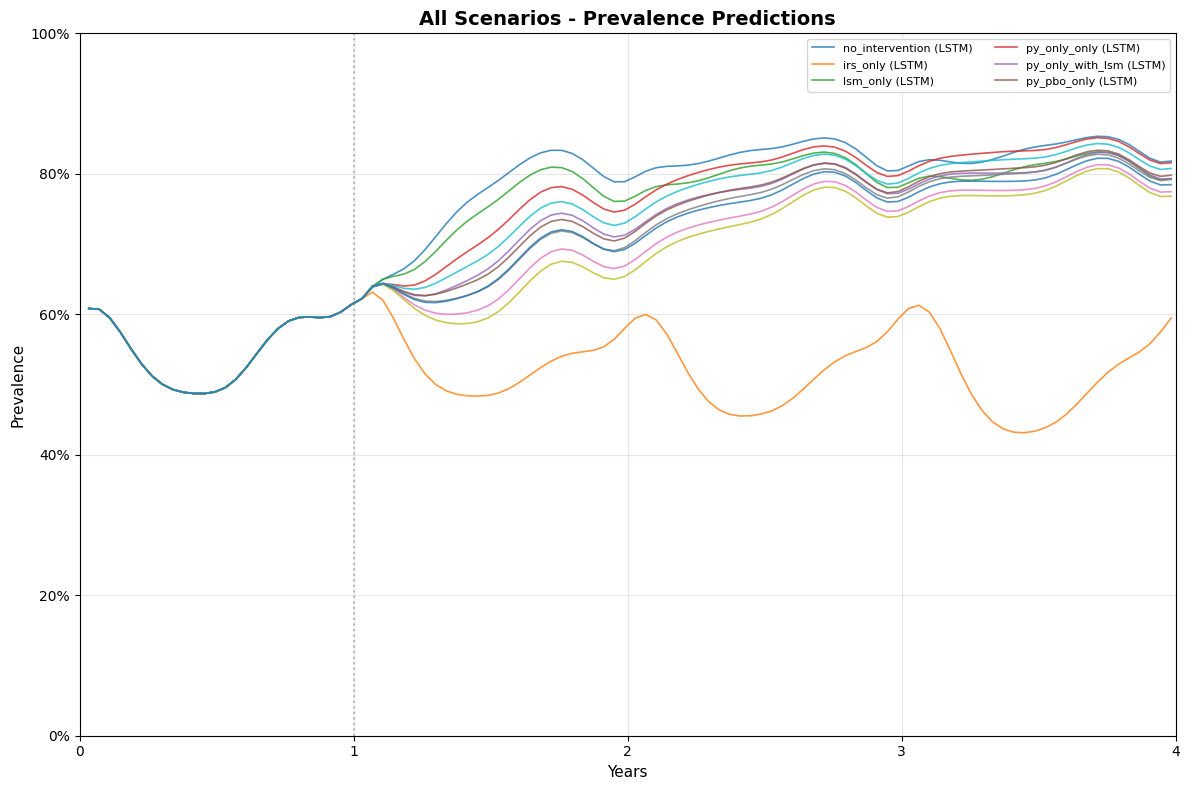

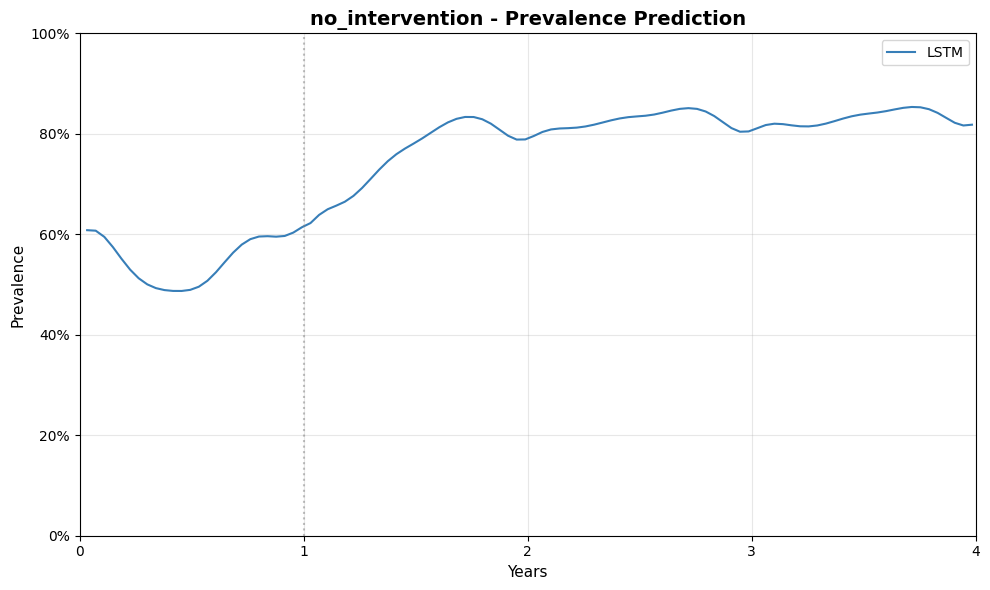

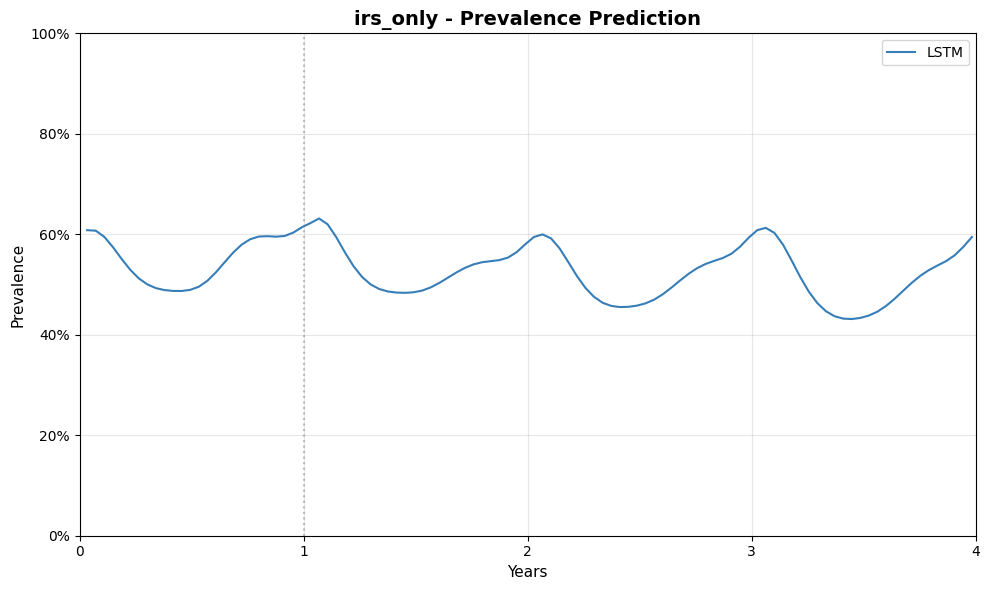

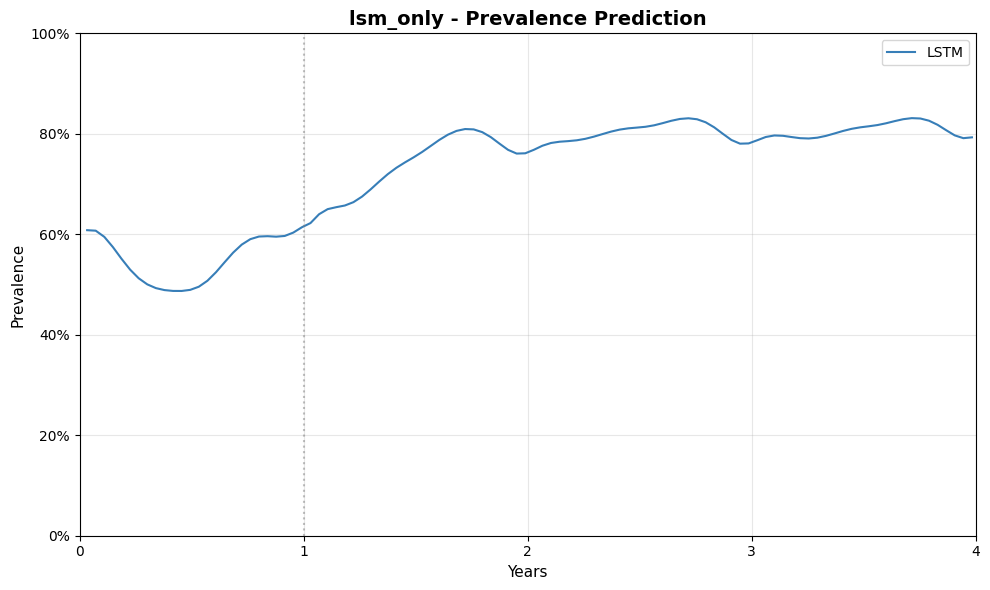

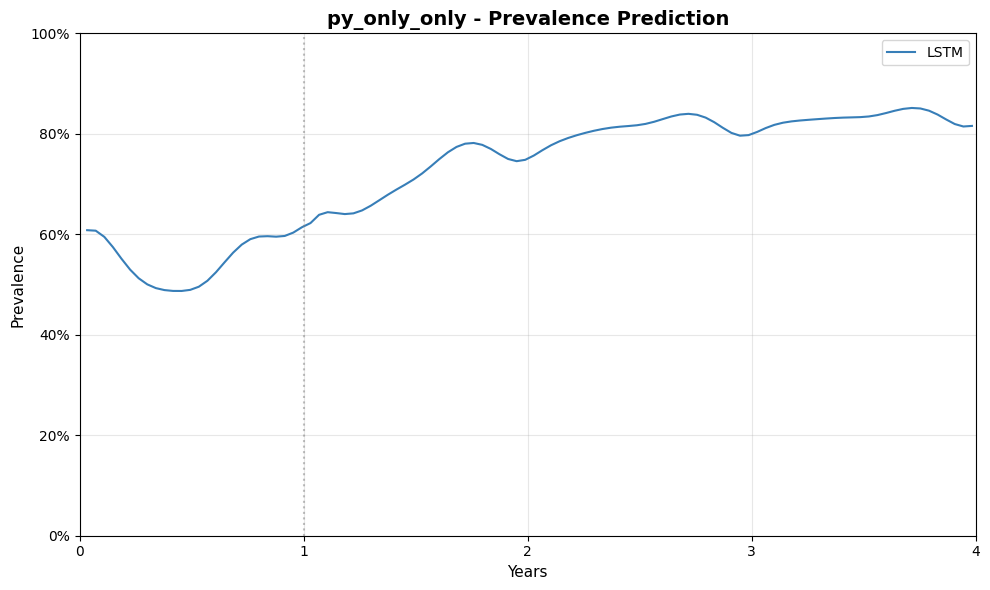

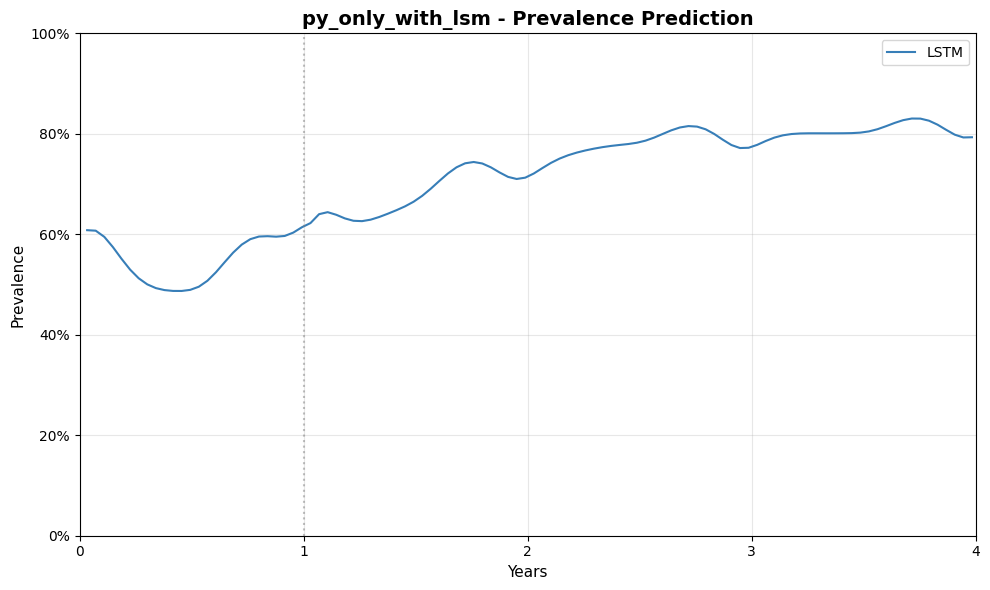

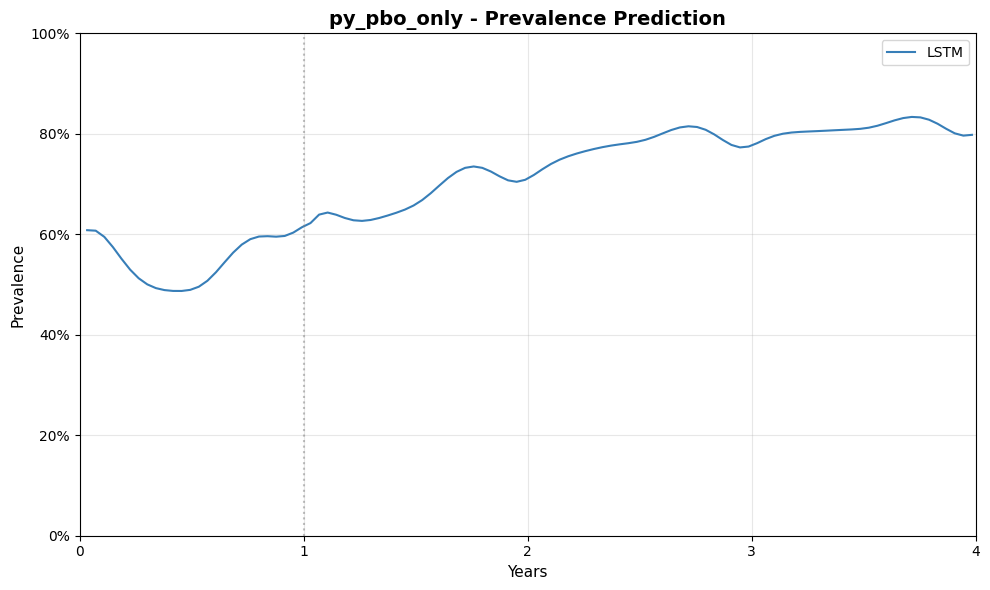

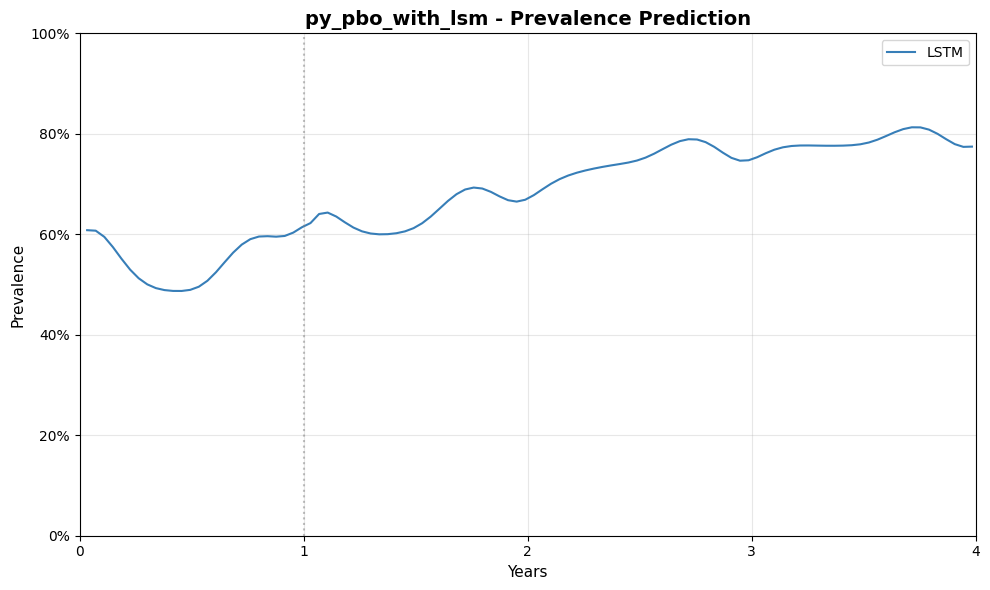

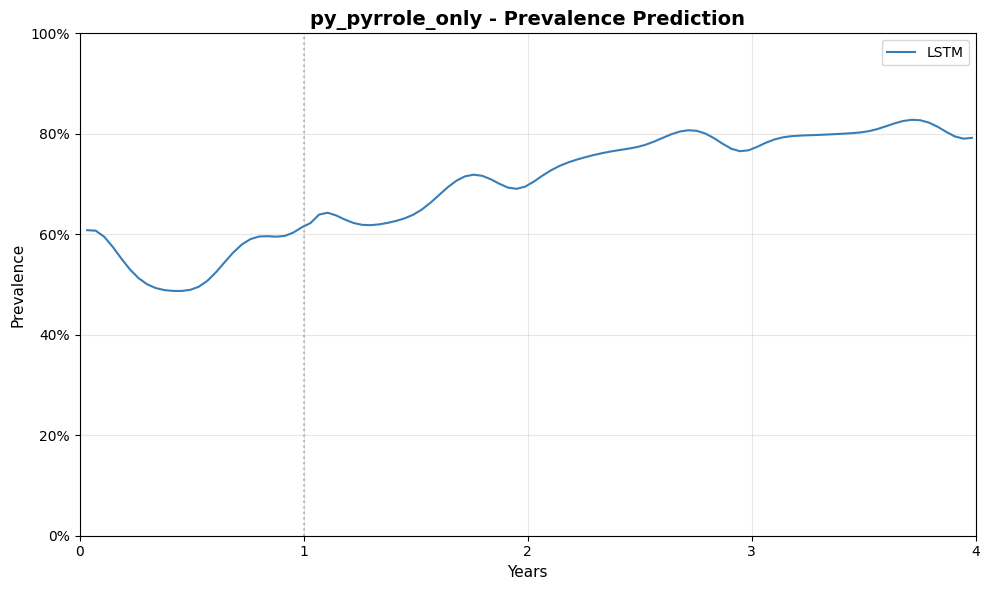

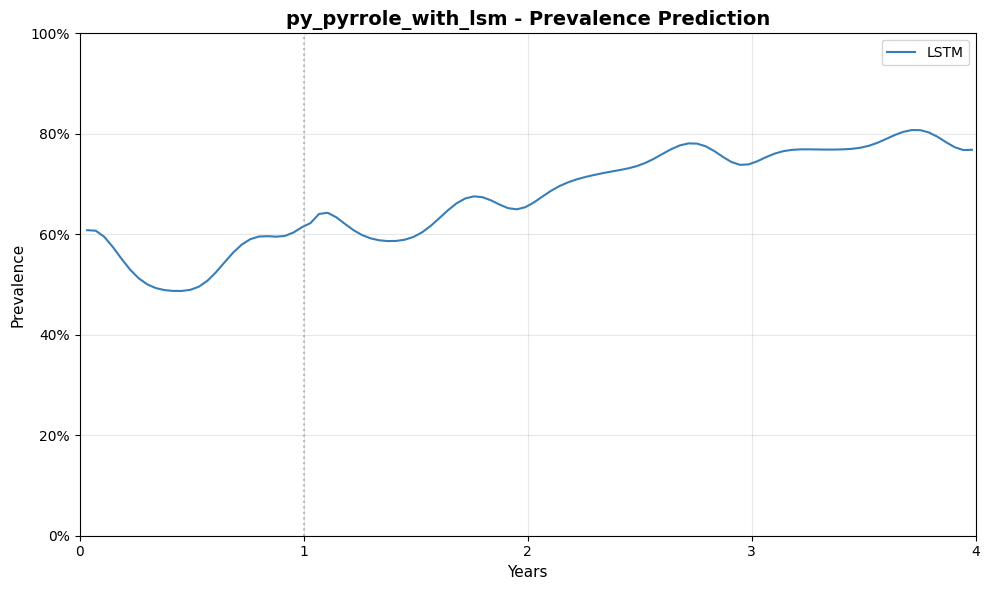

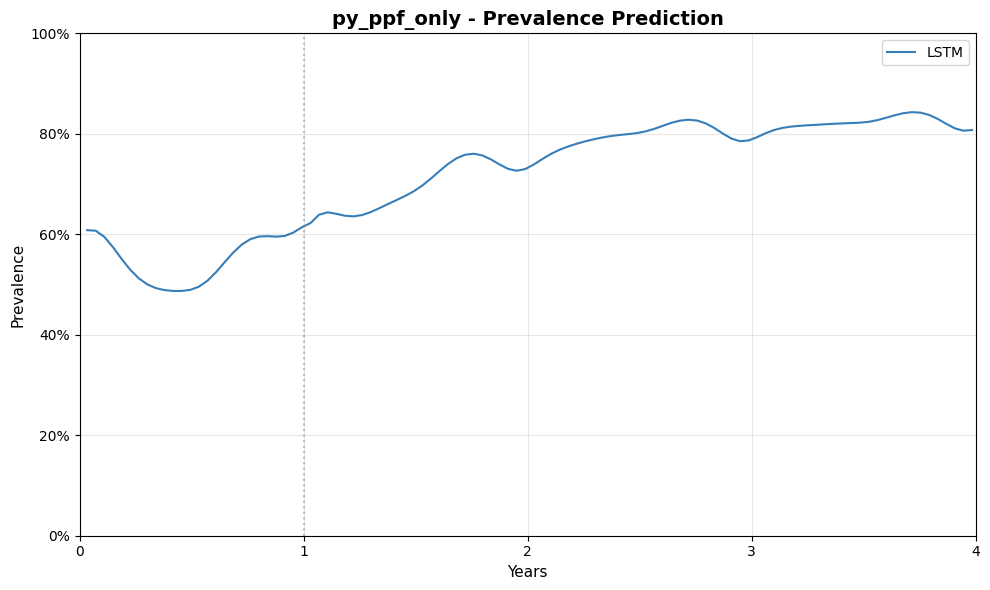

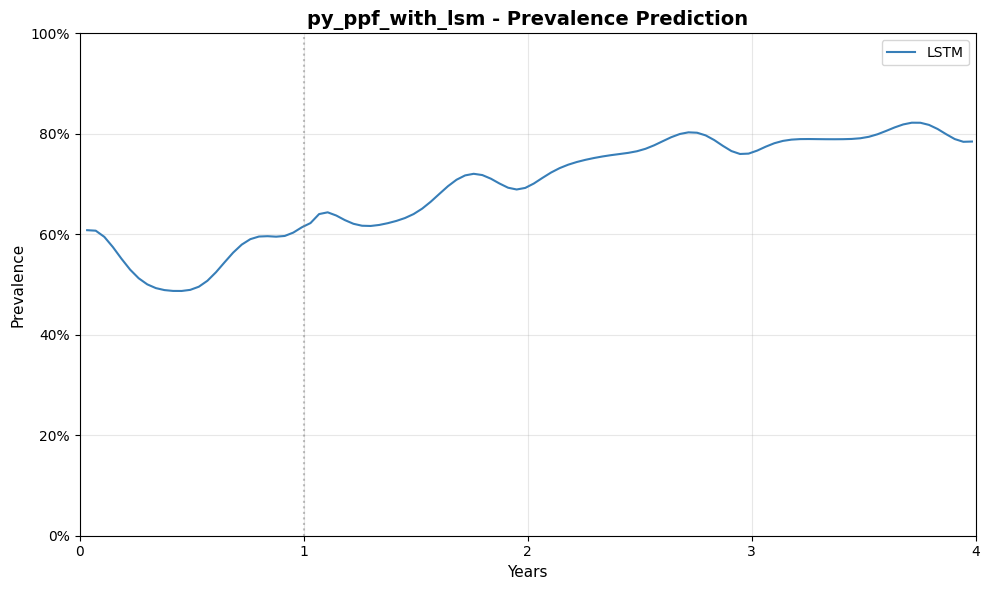

In [8]:
import os


# Create a folder for plots (if it doesn't exist)
os.makedirs("plots", exist_ok=True)

plots = create_scenario_plots(
    res.prevalence,
    output_dir="plots/",
    plot_type="both",   # "prevalence", "cases", or "both"
)

print("Created plots:", plots)



### Optional: quick inline plots with matplotlib

If you prefer to explore interactively inside the notebook, you can also
use `matplotlib` directly.


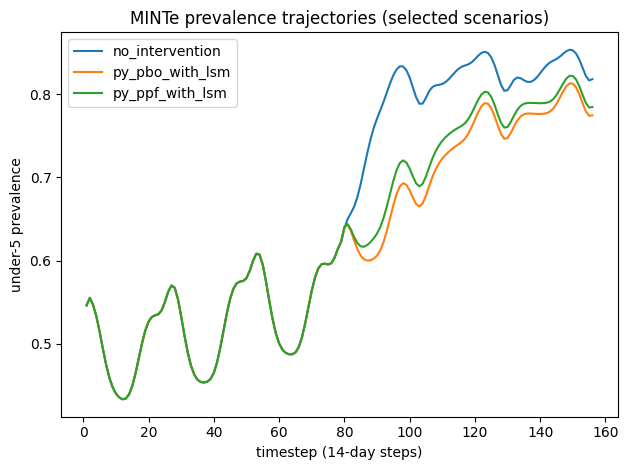

In [9]:
import matplotlib.pyplot as plt

# Make a copy and add a 'year' column (timestep * 14 days → years)
prev_df_years = prev_df.copy()
prev_df_years["year"] = prev_df_years["timestep"] * 14 / 365.0

# Example: plot prevalence trajectories for a few key scenarios inline
key_scenarios = ["no_intervention", "py_pbo_with_lsm", "py_ppf_with_lsm"]

fig, ax = plt.subplots()
for name, sub in prev_df_years[prev_df_years["scenario"].isin(key_scenarios)].groupby("scenario"):
    sub = sub.sort_values("year")
    ax.plot(sub["year"], sub["prevalence"], label=name)

ax.set_xlabel("time (years)")
ax.set_ylabel("under-5 prevalence")
ax.set_title("MINTe prevalence trajectories (selected scenarios)")
ax.legend()
plt.tight_layout()
plt.show()



## 10. Exporting results to CSV

Finally, we'll show how to save MINTe outputs to `.csv` so that:

- R users can read them back with `readr::read_csv`
- Analysts can use Excel / Stata / anything else

We typically export:
- the `prevalence` table
- the `cases` table
- the `scenario_meta` table


In [ ]:

output_folder = "minte_outputs"
os.makedirs(output_folder, exist_ok=True)

prev_df.to_csv(os.path.join(output_folder, "prevalence_multi.csv"), index=False)
cases_df.to_csv(os.path.join(output_folder, "cases_multi.csv"), index=False)
res.scenario_meta.to_csv(os.path.join(output_folder, "scenario_meta.csv"), index=False)

print("Saved CSV files to:", os.path.abspath(output_folder))
